# Plot jointcal chi2 outlier statistics

Plotting how jointcal's chi2 and outlier removal both evolve during fitting can help identify debug problematic fits.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks", {"legend.frameon": True})
sns.set_context("talk")

import numpy as np

The stdout log from a run of jointcal is all that's needed here.

In [2]:
# filename = "/data/validate/hsc-reprocess/jointcal-DM-13670-HSC-I.log"
filename = "../testcfht.log"
# filename = "/home/parejkoj/lsst/temp/sshfs-mount/DM-11783/logs/jointcal-SSP_UDEEP_COSMOS_9813_HSC-Y-125371.0.log"

In [3]:
outlierRe = re.compile(r"\(Measured \+ Reference \= Total\): ([0-9]*) \+ ([0-9]*) \= ([0-9]*)")
chi2Re = re.compile(r"")

# Extract data values from the TRACE logged measuredStar/refStar strings, by combining
# a set of smaller regexes that each capture "SomeString: number" (where number could be exponential).
# Example logged measuredStar removal:
#   Removing measStar x: 1098.63 y: 925.307 flux: 6.62099e-09 fluxErr: 9.44728e-11 instFlux: 43045.3 instFluxErr: 613.83 id: 131329456982720691 valid: 1 chi2: 9.99599
# Example logged refStar removal:
#   Removing refStar x: 214.827 y: 52.5021 flux: 2.3448e-08 fluxErr: 2.54008e-10 refFlux: [2.3448e-08, ] chi2: 9.71124
xRe = r"x: (?P<x>[+-]?\d+(?:.\d*)?)"
yRe = r"y: (?P<y>[+-]?\d+(?:.\d*)?)"
fluxRe = r"flux: (?P<flux>([+-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+))|(\d+(?:.\d*)?))"
fluxErrRe = r"fluxErr: (?P<fluxErr>([+-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+))|(\d+(?:.\d*)?))"
instFluxRe = r"instFlux: (?P<instFlux>([+-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+))|(\d+(?:.\d*)?))"
instFluxErrRe = r"instFluxErr: (?P<instFluxErr>([+-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+))|(\d+(?:.\d*)?))"
starChi2 = r"chi2: (?P<chi2>([+-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+))|(\d+(?:.\d*)?))"

measRemovedRe = re.compile("%s %s %s %s %s %s.*%s"%(xRe, yRe, fluxRe, fluxErrRe, instFluxRe, instFluxErrRe, starChi2))
refRemovedRe = re.compile("%s %s %s %s.*%s"%(xRe, yRe, fluxRe, fluxErrRe, starChi2))

class Outliers(object):
    """Extract chi-squared and outlier information from a jointcal log file."""
    def __init__(self, filename, startStr, endStr):
        self._read_outliers(filename, startStr, endStr)

    def _read_outliers(self, filename, startStr, endStr):
        """Extract information from a log, searching between startStr and endStr."""
        measOutliers = []
        refOutliers = []
        totalOutliers = []
        chi2 = []
        ndof = []
        chi2perndof = []
        initializedStr = "Fit prepared with"
        
        measRemoved = []
        refRemoved = []
        
        with open(filename) as file:
            # Skip over lines until we get to the line we want to start from.
            for line in file:
                if startStr in line:
                    break

            self.init_count = 0  # count the number of chi2 values pre-initialization
            post_init = False
            for line in file:
                matches = outlierRe.search(line)
                if endStr in line:
                    break
                elif initializedStr in line:
                    post_init = True
                elif matches is not None:
                    meas, ref, total = matches.group(1,2,3)
                    measOutliers.append(int(meas))
                    refOutliers.append(int(ref))
                    totalOutliers.append(int(total))
                elif "chi2/ndof" in line:
                    if not post_init:
                        self.init_count += 1
                    temp = line.split("chi2/ndof : ")[-1]
                    chi2perndof.append(float(temp.split('=')[1]))
                    temp = temp.split('=')[0].split('/')
                    chi2.append(float(temp[0]))
                    ndof.append(float(temp[1]))
                elif "Removing measStar" in line:
                    matches = measRemovedRe.search(line)
                    measRemoved.append((matches.group('instFlux'), matches.group('instFluxErr')))
                elif "Removing refStar" in line:
                    matches = refRemovedRe.search(line)
                    refRemoved.append((matches.group('flux'), matches.group('fluxErr')))
                else:
                    continue

        self.measOutliers = np.array(measOutliers, dtype=np.float64)
        self.refOutliers = np.array(refOutliers, dtype=np.float64)
        self.totalOutliers = np.array(totalOutliers, dtype=np.float64)
        self.chi2 = np.array(chi2, dtype=np.float64)
        self.ndof = np.array(ndof, dtype=np.float64)
        self.chi2perndof = np.array(chi2perndof, dtype=np.float64)
        self.measRemoved = np.array(measRemoved, dtype=np.float64)
        self.refRemoved = np.array(refRemoved, dtype=np.float64)

    def plot_outliers(self, max_chi2=None):
        """Plot the chi2 and removed outliers as adjacent panels."""

        fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))

        xrange = np.arange(0, len(self.chi2perndof), dtype=float)
        ax0.set_yscale("log")
        ax0.axhline(1, color='grey', ls='--')
        ax0.axvline(self.init_count-0.5, color='grey', lw=0.9)
        # ax0.set_ylim([0.5,100])
        ax0.plot(xrange[:self.init_count], self.chi2perndof[:self.init_count], '*', ms=10, color='black',
                label="pre-init")
        ax0.plot(xrange[self.init_count:], self.chi2perndof[self.init_count:], 'o', ms=10,
                label="post-init")
        if max_chi2 is not None:
            ax0.set_ylim(0.1, max_chi2)
        ax0.set_xlabel("Iteration #", fontsize=20)
        ax0.set_ylabel("$\chi ^2$", fontsize=20)
        ax0.legend(loc="upper right")

        xrange = np.arange(self.init_count, len(self.measOutliers) + self.init_count, dtype=float)
        ax1.plot(xrange, self.measOutliers, 's', label='meas', ms=10)
        ax1.plot(xrange, self.refOutliers, 'o', label='ref', ms=10)
        ax1.set_xlabel("Iteration #", fontsize=20)
        ax1.set_ylabel("# of outliers removed", fontsize=20)
        ax1.legend(loc="upper right")

In [4]:
astrometry = Outliers(filename, "Starting astrometric fitting...", "Updating WCS for visit:")
photometry = Outliers(filename, "Starting photometric fitting...", "Updating PhotoCalib for visit:")

(array([2., 0., 1., 2., 5., 1., 4., 1., 1., 0., 1., 8., 4., 2., 0., 0., 0.,
        0., 0., 1., 2., 5., 1., 0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0.,
        0., 0., 0., 0., 4., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 10.1533544 ,  12.06166485,  13.9699753 ,  15.87828574,
         17.78659619,  19.69490664,  21.60321708,  23.51152753,
         25.41983798,  27.32814842,  29.23645887,  31.14476932,
         33.05307976,  34.96139021,  36.86970066,  38.7780111 ,
         40.68632155,  42.594632  ,  44.50294244,  46.41125289,
         48.31956334,  50.22787378,  52.13618423,  54.04449468,
         55.95280512,  57.86111557,  59.76942602,  61.67773646,
         63.58604691,  65.49435736,  67.4026678 ,  69.31097825,
         71.2192887 ,  73.12759914,  7

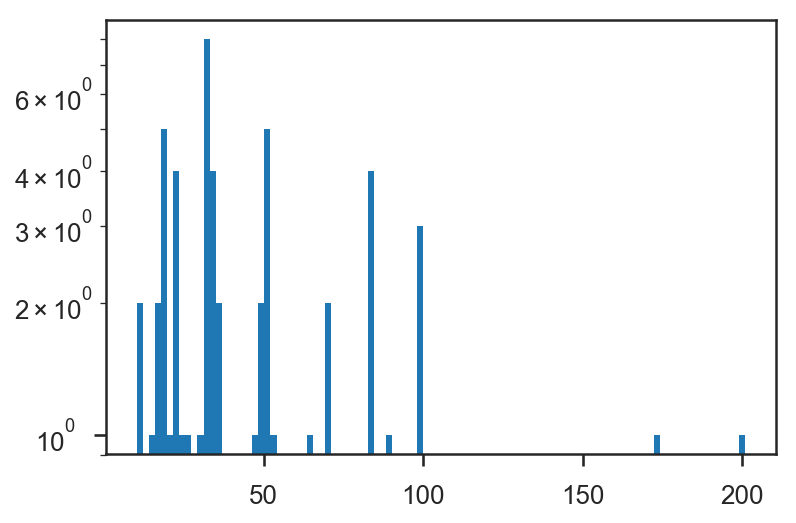

In [5]:
plt.hist(photometry.measRemoved[:,0]/photometry.measRemoved[:,1], bins=100, log=True)

## Astrometry outlier removal

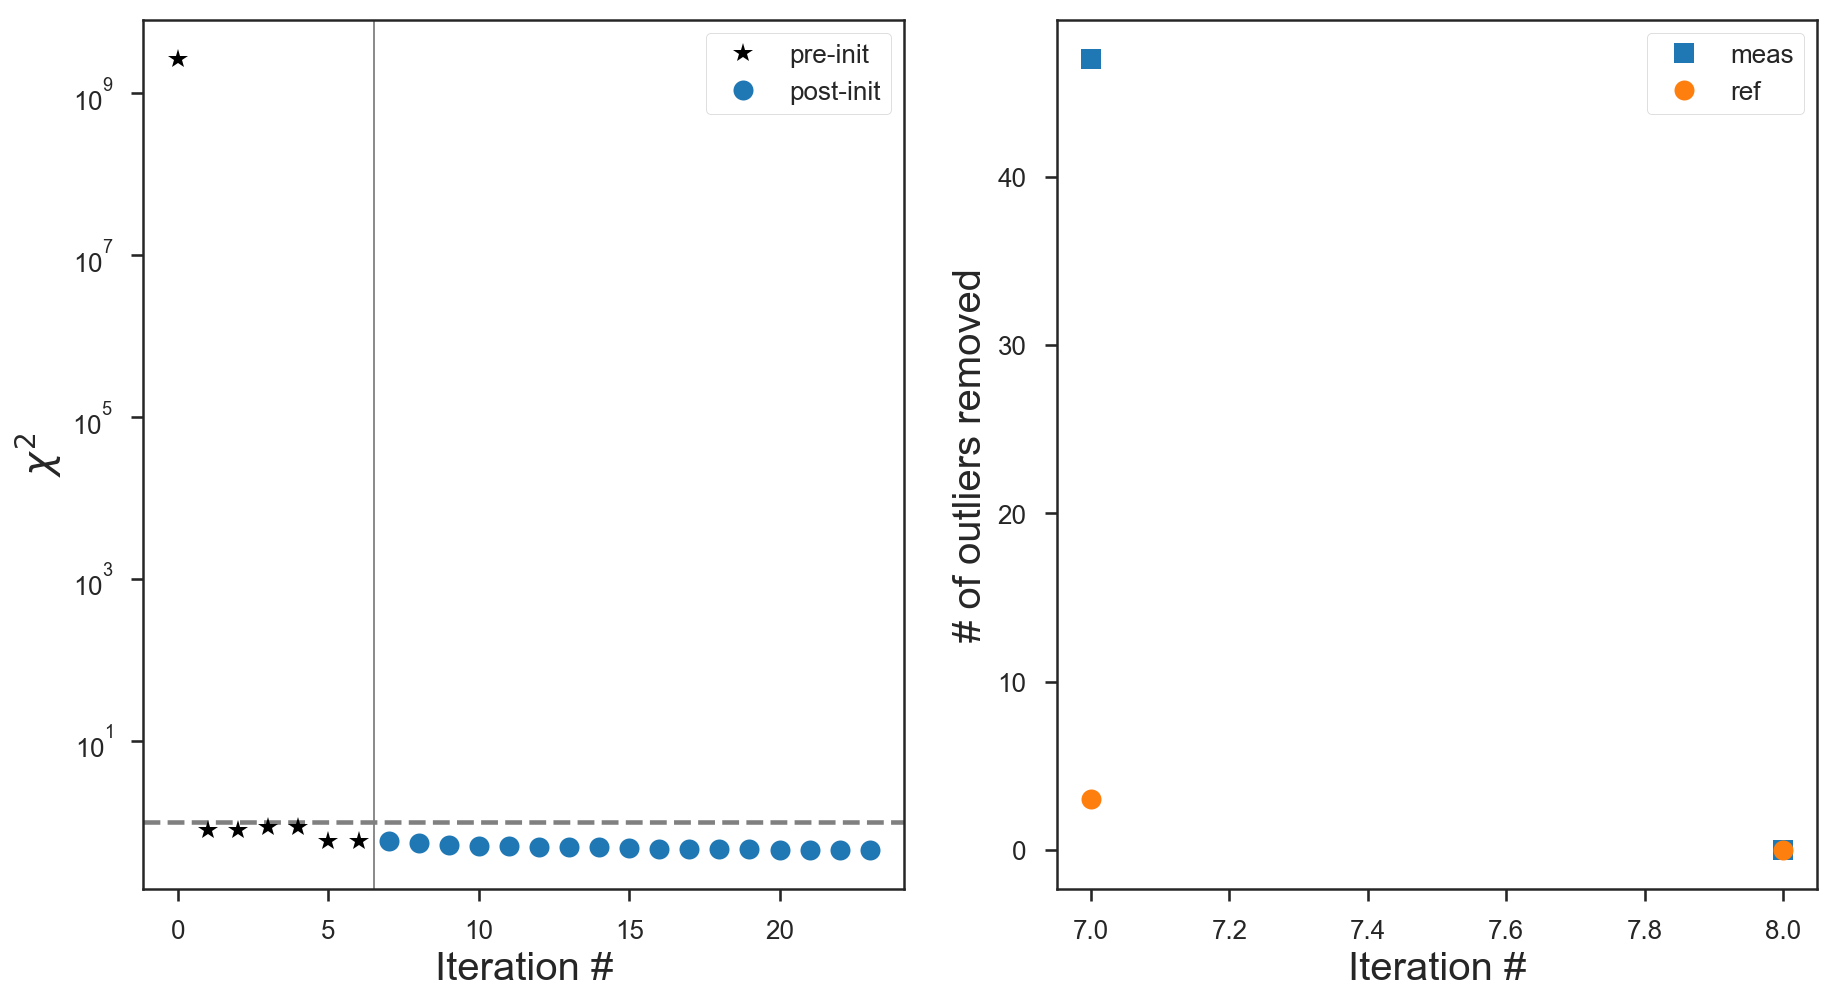

In [6]:
astrometry.plot_outliers()#, max_chi2=100)

## Photometry outlier removal

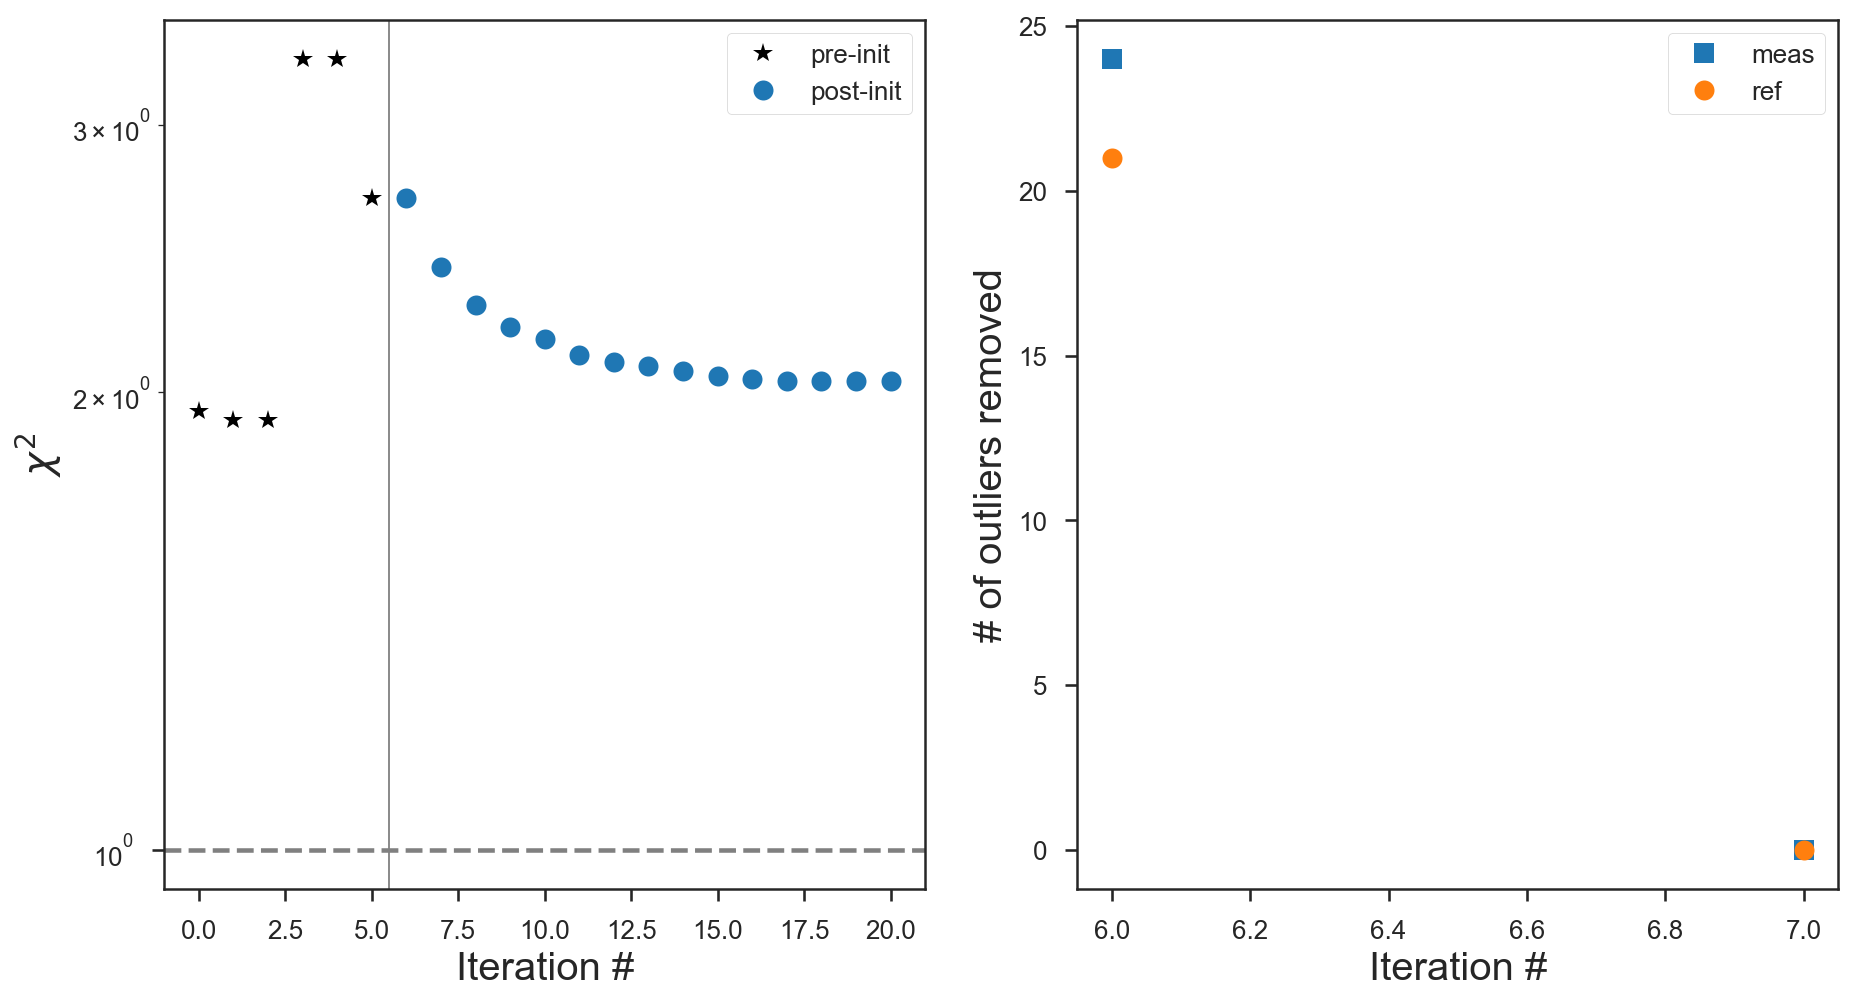

In [7]:
photometry.plot_outliers()